In [155]:
import os, torch, pandas as pd, numpy as np, matplotlib.pyplot as plt
from torch import nn
from torch.nn import Linear, ReLU, Sequential
from torch_geometric.nn import NNConv

import geopandas as gpd
from shapely.geometry import Point
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
import torch.nn.functional as F

In [ ]:
NODES_EPSG = 5174

# ---------- paths ----------
BASE_DIR = 'D:/Desktop/mobility-seoul/'  # Change this to your base directory!

CLIMATE_URBAN = os.path.join(BASE_DIR, "Results/models/gnn_climate_urban.pth")
CLIMATE = os.path.join(BASE_DIR, "Results/models/gnn_climate.pth")
BASELINE = os.path.join(BASE_DIR, "Results/models/gnn_baseline.pth")

ART_CLIMATE_URBAN  = os.path.join(BASE_DIR, "Results/models/gnn_climate_urban_dataset_artifacts.pt")
ART_CLIMATE       = os.path.join(BASE_DIR, "Results/models/gnn_climate_dataset_artifacts.pt")
ART_BASELINE      = os.path.join(BASE_DIR, "Results/models/gnn_baseline_dataset_artifacts.pt")

NODES_CSV = os.path.join(BASE_DIR, "graph_components/graph_components_intersections/node_urban_features.csv")
OUT_DIR   = os.path.join(BASE_DIR, "Results/scenario_maps")
SCENARIO_DIR = os.path.join(BASE_DIR, "Results/scenarios")

BUILDING_SHP = os.path.join(BASE_DIR, "Data/GIS data/Building footprints/merge_valid.shp")
GREEN_SHP = os.path.join(BASE_DIR, "Data/GIS data/Urban cropped/landuse_cropped.shp")
STATIONS_SHP = os.path.join(BASE_DIR, "Data/GIS data/Urban cropped/transport_seoul.shp")
RIVER_SHP = os.path.join(BASE_DIR, "Data/GIS data/south-korea-osm.shp/gis_osm_water_a_free_1.shp")
EXTENTS_SHP = os.path.join(BASE_DIR, "Data/GIS data/Extents/Seoul extents/seoul_extents.shp")

NEIGHBORHOODS_SHP = os.path.join(BASE_DIR, "Data/GIS data/Extents/Seoul_municipalities/seoul_submunicipalities.shp")

In [ ]:
buildings_gdf = gpd.read_file(BUILDING_SHP).to_crs(f"EPSG:{NODES_EPSG}")

In [ ]:
green_gdf = gpd.read_file(GREEN_SHP).to_crs(f"EPSG:{NODES_EPSG}")
green_types = ['allotments', 'cemetery', 'farmland', 'farmyard', 'forest', 'grass', 'heath', 'meadow',
               'nature_reserve', 'orchard', 'park', 'scrub', 'vineyard'] # only these types are considered green areas
green_gdf = green_gdf[green_gdf['fclass'].isin(green_types)]
green_gdf = green_gdf.explode(index_parts=False).reset_index(drop=True)
green_union = green_gdf.union_all()
green_gdf = gpd.GeoDataFrame(geometry=[green_union], crs=f"EPSG:{NODES_EPSG}")

stations_gdf = gpd.read_file(STATIONS_SHP).to_crs(f"EPSG:{NODES_EPSG}")
stations_gdf = stations_gdf[stations_gdf['fclass'] == 'railway_station']

In [159]:
# print green gdf crs
print(green_gdf.crs)

EPSG:5174


In [ ]:
river_gdf = gpd.read_file(RIVER_SHP).to_crs(f"EPSG:{NODES_EPSG}")
river_gdf = river_gdf[river_gdf['fclass'] == 'riverbank']
river_gdf = river_gdf.explode(index_parts=False).reset_index(drop=True)


city_gdf  = gpd.read_file(EXTENTS_SHP).to_crs(f"EPSG:{NODES_EPSG}")
x0, y0, x1, y1 = city_gdf.total_bounds
river_gdf = river_gdf.cx[x0:x1, y0:y1]

NEIGH_NAMES = ["Heukseok-dong", "Noryangjin 1(il)-dong" ] #"Sangdo 1(il)-dong"
neigh_gdf = gpd.read_file(NEIGHBORHOODS_SHP).to_crs(f"EPSG:{NODES_EPSG}")
neigh_selected = neigh_gdf[neigh_gdf['name_eng'].isin(NEIGH_NAMES)]
neigh_union = neigh_selected.geometry.union_all()
nx0, ny0, nx1, ny1 = neigh_union.bounds
buildings_gdf = buildings_gdf.cx[nx0:nx1, ny0:ny1]

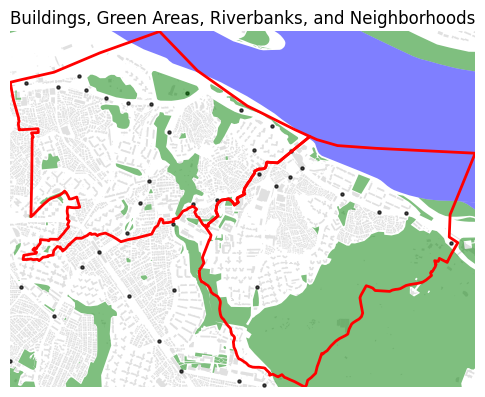

In [ ]:
nodes_df = pd.read_csv(NODES_CSV)
nodes_gdf = gpd.GeoDataFrame(
    nodes_df.copy(),
    geometry=gpd.points_from_xy(nodes_df["node_x"], nodes_df["node_y"]),
    crs=f"EPSG:{NODES_EPSG}"
)

# plot the nodes and green and buildings and river and zoom into neighborhoods
ax = buildings_gdf.plot(figsize=(6, 6), color="lightgrey", alpha=0.7)
nodes_gdf.plot(ax=ax, color="black", markersize=5, alpha=0.7)
green_gdf.plot(ax=ax, color="green", alpha=0.5)
river_gdf.plot(ax=ax, color="blue", alpha=0.5)
neigh_selected.boundary.plot(ax=ax, color="red", linewidth=2)
ax.set_title("Buildings, Green Areas, Riverbanks, and Neighborhoods")
ax.set_xlim(nx0, nx1)
ax.set_ylim(ny0, ny1)
ax.set_axis_off()
plt.show()

In [162]:
INTERVALS = [
    (8, 10),   # 08:00–10:00
    (12, 14),  # 12:00–14:00
    (16, 18),  # 16:00–18:00
    (18, 20),  # 18:00–20:00
]

In [163]:
# ---------- model definition (matches training) ----------
class EdgeAwareTemporalEncoder(nn.Module):
    def __init__(self, in_channels, edge_feat_dim, hidden_dim):
        super().__init__()
        self.edge_nn = Sequential(Linear(edge_feat_dim, 32), ReLU(), Linear(32, in_channels * hidden_dim))
        self.conv = NNConv(in_channels=in_channels, out_channels=hidden_dim, nn=self.edge_nn, aggr='mean')
        self.gru  = nn.GRUCell(hidden_dim, hidden_dim)

    def forward(self, x_seq, edge_index_seq, edge_attr_seq):
        h = None
        for x, ei, ea in zip(x_seq, edge_index_seq, edge_attr_seq):
            out = self.conv(x, ei, ea)
            h = out if h is None else self.gru(out, h)
        return h

class MovementLinkPredictor(nn.Module):
    def __init__(self, in_channels, encoder_edge_feat_dim, time_feat_dim, hidden_dim):
        super().__init__()
        self.encoder = EdgeAwareTemporalEncoder(in_channels, encoder_edge_feat_dim, hidden_dim)
        self.node_decoder = nn.Sequential(Linear(hidden_dim + time_feat_dim, 64), ReLU(), Linear(64, 1))

    def forward_encoder(self, x_seq, edge_index_seq, edge_attr_seq):
        return self.encoder(x_seq, edge_index_seq, edge_attr_seq)

    def predict_node_counts(self, z, time_feat):
        return self.node_decoder(torch.cat([z, time_feat], dim=1)).squeeze(1)


In [164]:
# ---------- evaluator ----------

def count_to_probability(counts, eps=1e-6):
    p = torch.clamp(counts, 0.0, 1.0)
    return torch.clamp(p, eps, 1 - eps)

@torch.no_grad()
def eval_nodes_for_bins(model, features, edge_indices, edge_features, targets,
                        bins, bin_context, window_size, thr=0.3):
    """
    Returns node-level metrics over all selected bins:
      - MSE on counts
      - Precision/Recall/F1 for presence (visited vs not visited)
    """
    true_counts_all = []
    pred_counts_all = []
    true_binary_all = []
    pred_binary_all = []

    N = features[0].shape[0]
    model.eval()

    for t in bins:
        if t < window_size: 
            continue
        if all(ei.size(1) == 0 for ei in edge_indices[t-window_size:t]):
            continue

        z = model.forward_encoder(
            features[t-window_size:t],
            edge_indices[t-window_size:t],
            edge_features[t-window_size:t]
        )

        h_norm, d_norm = bin_context[t]
        node_time = torch.tensor([[h_norm, d_norm]], dtype=torch.float).repeat(N, 1)
        pred = model.predict_node_counts(z, node_time)           # shape [N]
        true = targets[t-1][0]                                   # your node target at t-1

        # collect (CPU numpy)
        pred_np = pred.detach().cpu().numpy()
        true_np = true.detach().cpu().numpy()

        # presence (same trick you used)
        p_active = count_to_probability(pred).detach().cpu().numpy()
        pred_bin = (p_active >= thr).astype(int)
        true_bin = (true_np >= 1).astype(int)

        pred_counts_all.append(pred_np)
        true_counts_all.append(true_np)
        pred_binary_all.append(pred_bin)
        true_binary_all.append(true_bin)

    if not pred_counts_all:  # no valid windows
        return dict(mse=np.nan, precision=np.nan, recall=np.nan, f1=np.nan)

    y_pred = np.concatenate(pred_counts_all, axis=0)
    y_true = np.concatenate(true_counts_all, axis=0)
    yb_pred = np.concatenate(pred_binary_all, axis=0)
    yb_true = np.concatenate(true_binary_all, axis=0)

    mse = mean_squared_error(y_true, y_pred)
    precision = precision_score(yb_true, yb_pred, zero_division=0)
    recall = recall_score(yb_true, yb_pred, zero_division=0)
    f1 = f1_score(yb_true, yb_pred, zero_division=0)

    return dict(mse=float(mse), precision=float(precision), recall=float(recall), f1=float(f1))

In [165]:
# ---------- helpers ----------
@torch.no_grad()
def predict_nodes_for_bins(model, features, edge_indices, edge_features, targets, bins, bin_context, window_size):
    rows, N = [], features[0].shape[0]
    model.eval()
    for t in bins:
        if t < window_size:
            continue
        if all(ei.size(1) == 0 for ei in edge_indices[t-window_size:t]):
            continue
        z = model.forward_encoder(features[t-window_size:t], edge_indices[t-window_size:t], edge_features[t-window_size:t])
        h_norm, d_norm = bin_context[t]
        node_time = torch.tensor([[h_norm, d_norm]], dtype=torch.float).repeat(N, 1)
        pred = model.predict_node_counts(z, node_time)
        for nid in range(N):
            rows.append({"time_bin": int(t), "node_id": int(nid), "pred_count": float(pred[nid].item())})
    return pd.DataFrame(rows)

def _ensure_datetime_columns(bin_context, start_time_dt, interval):
    """Return a dict t->(dt, hour, dow) using real timestamps when available; fallback to normalized."""
    meta = {}
    for t, (h_norm, d_norm) in bin_context.items():
        if (start_time_dt is not None) and (interval is not None):
            dt = start_time_dt + pd.Timedelta(seconds=int(interval) * t) + pd.Timedelta(seconds=int(interval)//2)
            hour = dt.hour + dt.minute / 60.0
            dow  = dt.dayofweek  # Mon=0..Sun=6
            meta[int(t)] = (dt, hour, dow)
        else:
            hour = 23.0 * float(h_norm)
            dow  = int(round(6.0 * float(d_norm)))
            meta[int(t)] = (None, hour, dow)
    return meta

def select_bins_by_days_and_hours(bin_context, start_time_dt, interval, day_selector, hour_range_list, weekdays_only=False):
    """
    day_selector:
      - None -> all days
      - list/iterable of 'YYYY-MM-DD' strings
      - tuple ('YYYY-MM-DD', 'YYYY-MM-DD') inclusive range
    hour_range_list: list of (start_hour, end_hour) with end exclusive
    """
    meta = _ensure_datetime_columns(bin_context, start_time_dt, interval)

    allowed_dates = None
    if day_selector is None:
        allowed_dates = None
    else:
        if isinstance(day_selector, (list, tuple, set)) and not (isinstance(day_selector, tuple) and len(day_selector) == 2):
            allowed_dates = set(pd.to_datetime(d).date() for d in day_selector)
        elif isinstance(day_selector, tuple) and len(day_selector) == 2:
            d0 = pd.to_datetime(day_selector[0]).date()
            d1 = pd.to_datetime(day_selector[1]).date()
            allowed_dates = set(pd.date_range(d0, d1, freq="D").date)
        else:
            allowed_dates = {pd.to_datetime(day_selector).date()}

    out = []
    for t, (dt, hour, dow) in meta.items():
        if weekdays_only and dow is not None and dow > 4:
            continue
        if allowed_dates is not None and dt is not None:
            if dt.date() not in allowed_dates:
                continue
        if any(h0 <= hour < h1 for (h0, h1) in hour_range_list):
            out.append(t)
    return sorted(set(out))

def aggregate(pred_df, how="mean"):
    g = pred_df.groupby("node_id")["pred_count"]
    if how == "mean":
        res = g.mean()
    elif how == "peak":
        res = g.max()
    else:
        raise ValueError("how must be 'mean' or 'peak'")
    return res.reset_index().rename(columns={"pred_count":"value"})


In [166]:
# ---------- plotting  ----------
def plot_grid_2x4_gpd(
    nodes_gdf, mean_dfs, peak_dfs, titles_row1, titles_row2, out_path,
    vmin_row1=None, vmax_row1=None, vmin_row2=None, vmax_row2=None,
    zero_cutoff=0.0, cmap="viridis", show=True,
    zoom_geom=None,              # polygon to zoom to
    zoom_marker_size=27,
    metrics_per_interval=None,
    overall_metrics=None 
):
    """
    Renders 4 rows × 5 columns (last col = colorbars on rows 0 & 2):
      Row 0: Mean (full extent)
      Row 1: Mean (zoom to neighborhoods)
      Row 2: Peak (full extent)
      Row 3: Peak (zoom to neighborhoods)

    Assumptions (per your request):
      • zoom_geom is valid and non-empty.
      • neighborhoods_gdf is in the same CRS as nodes (optional, for boundaries only).
    """
    assert len(mean_dfs) == len(peak_dfs) == 4, "Expect 4 intervals for each row"

    # Merge values into GeoDataFrames
    merged_mean = [nodes_gdf.merge(df, on="node_id", how="left") for df in mean_dfs]
    merged_peak = [nodes_gdf.merge(df, on="node_id", how="left") for df in peak_dfs]

    # Shared color limits per row
    if vmin_row1 is None or vmax_row1 is None:
        vals = pd.concat([m["value"].dropna() for m in merged_mean], axis=0)
        vmin_row1, vmax_row1 = float(vals.min()), float(vals.max())
    if vmin_row2 is None or vmax_row2 is None:
        vals = pd.concat([p["value"].dropna() for p in merged_peak], axis=0)
        vmin_row2, vmax_row2 = float(vals.min()), float(vals.max())

    norm1 = Normalize(vmin=vmin_row1, vmax=vmax_row1)
    norm2 = Normalize(vmin=vmin_row2, vmax=vmax_row2)

    # Exact zoom bounds
    zx0, zy0, zx1, zy1 = zoom_geom.bounds

    # -------- LAYOUT: 4 rows × 5 cols (last col for colorbars on rows 0 & 2) --------
    fig = plt.figure(figsize=(18, 15))
    gs = fig.add_gridspec(
        nrows=4, ncols=5,
        width_ratios=[1, 1, 1, 1, 0.035],
        height_ratios=[1, 0.75, 1, 0.75],
        wspace=0.05, hspace=0.25
    )

    axes = np.empty((4, 4), dtype=object)
    for r in range(4):
        for c in range(4):
            axes[r, c] = fig.add_subplot(gs[r, c])

    # Colorbar axes (only for main rows)
    cax_mean = fig.add_subplot(gs[0, 4])
    cax_peak = fig.add_subplot(gs[2, 4])

    # Base overlays
    def _draw_base(ax):
        city_gdf.boundary.plot(ax=ax, edgecolor="crimson", linewidth=0.2, zorder=2)
        river_gdf.plot(ax=ax, facecolor="steelblue", edgecolor="none",
                                linewidth=1.2, alpha=0.2, zorder=1)

    def _plot_points(ax, gdf_i, vmin, vmax, size=8):
        
        if zero_cutoff > 0:
            zero = gdf_i[gdf_i["value"].fillna(0) <= zero_cutoff]
            pos  = gdf_i[gdf_i["value"].fillna(0) >  zero_cutoff]
            if len(zero):
                zero.plot(ax=ax, color="none", edgecolor="black",
                          linewidth=0.3, markersize=size, zorder=3, alpha=1)
        else:
            pos = gdf_i

        if len(pos):
            pos_sorted = pos.sort_values("value")
            pos_sorted.plot(
                ax=ax, column="value", cmap=cmap, markersize=size,
                edgecolor='black', linewidth=0.3,
                vmin=vmin, vmax=vmax, legend=False, zorder=4
            )

    # ---- Row 0: mean (full extent) ----
    for ax, gdf_i, title in zip(axes[0], merged_mean, titles_row1):
        _draw_base(ax)
        _plot_points(ax, gdf_i, vmin_row1, vmax_row1, size=8)
        ax.set_xlim(x0, x1); ax.set_ylim(y0, y1); ax.set_aspect("equal")
        ax.set_title(title, pad=10); ax.set_axis_off()

    # Mean colorbar
    sm1 = ScalarMappable(norm=norm1, cmap=cmap); sm1.set_array([])
    cbar1 = fig.colorbar(sm1, cax=cax_mean); cbar1.set_label("Mean predicted value")

    # ---- Row 1: mean (zoom to neighborhoods) ----
    for ax, gdf_i in zip(axes[1], merged_mean):
        green_gdf.plot(ax=ax, facecolor="yellowgreen", edgecolor="none",
             linewidth=0.1, alpha=0.2, zorder=1)
        buildings_gdf.boundary.plot(ax=ax, color="lightgrey", edgecolor="none", linewidth=0.1, alpha=1, zorder=1)
        buildings_gdf[buildings_gdf['BUL_ENG_NM'] == 'Law hall'].plot(ax=ax, color="mediumpurple", edgecolor="mediumpurple", joinstyle="miter", linewidth=0, alpha=1, zorder=1)
        
        _draw_base(ax)
        stations_gdf.plot(ax=ax, color="crimson", marker="s", markersize=7, edgecolor="none", linewidth=0, alpha=0.6, zorder=5)
        # filter nodes strictly inside zoom geometry to keep only neighborhood points
        gdf_zoom = gdf_i.cx[zx0:zx1, zy0:zy1]
        _plot_points(ax, gdf_zoom, vmin_row1, vmax_row1, size=zoom_marker_size)
        ax.set_xlim(zx0, zx1); ax.set_ylim(zy0, zy1); ax.set_aspect("equal")
        ax.set_title("Zoom — neighborhoods", fontsize=9, pad=6)
        ax.set_axis_off()

    # ---- Row 2: peak (full extent) ----
    for ax, gdf_i, title in zip(axes[2], merged_peak, titles_row2):
        _draw_base(ax)
        _plot_points(ax, gdf_i, vmin_row2, vmax_row2, size=8)
        ax.set_xlim(x0, x1); ax.set_ylim(y0, y1); ax.set_aspect("equal")
        ax.set_title(title, pad=10); ax.set_axis_off()

    # Peak colorbar
    sm2 = ScalarMappable(norm=norm2, cmap=cmap); sm2.set_array([])
    cbar2 = fig.colorbar(sm2, cax=cax_peak); cbar2.set_label("Peak predicted value")

    # ---- Row 3: peak (zoom to neighborhoods) ----
    for ax, gdf_i in zip(axes[3], merged_peak):
        green_gdf.plot(ax=ax, facecolor="yellowgreen", edgecolor="none", linewidth=0.1, alpha=0.2, zorder=1)
        buildings_gdf.boundary.plot(ax=ax, color="lightgrey", edgecolor="none", linewidth=0.1, alpha=1, zorder=1)
        buildings_gdf[buildings_gdf['BUL_ENG_NM'] == 'Law hall'].plot(ax=ax, color="mediumpurple", edgecolor="mediumpurple", joinstyle="miter", linewidth=0, alpha=1, zorder=1)
        _draw_base(ax)
        stations_gdf.plot(ax=ax, color="crimson", marker="s", markersize=7, edgecolor="none", linewidth=0, alpha=0.6, zorder=5)
        gdf_zoom = gdf_i.cx[zx0:zx1, zy0:zy1]
        _plot_points(ax, gdf_zoom, vmin_row2, vmax_row2, size=zoom_marker_size)
        ax.set_xlim(zx0, zx1); ax.set_ylim(zy0, zy1); ax.set_aspect("equal")
        ax.set_title("Zoom — neighborhoods", fontsize=9, pad=6)
        ax.set_axis_off()

    fig.suptitle("Predicted Node Values — Mean / Mean-Zoom / Peak / Peak-Zoom", y=0.99)
    fig.tight_layout(rect=[0, 0, 0.98, 0.965])

    # per-hour metrics
    if metrics_per_interval is not None and len(metrics_per_interval) == 4:
        for col in range(4):
            m = metrics_per_interval[col]
            txt = f"MSE={m['mse']:.2f}  |  P={m['precision']:.2f},  R={m['recall']:.2f}"
            ax_anchor = axes[3, col]  # bottom (peak-zoom) axis of this column
            bb = ax_anchor.get_position()
            x = (bb.x0 + bb.x1) / 2
            y = bb.y0 - 0.02          # a bit below the axis
            fig.text(x, y, txt, ha="center", va="top", fontsize=9, color="dimgray")

    # overall scenario metrics
    if overall_metrics is not None:
        t = overall_metrics
        overall_txt = f"OVERALL (all selected bins):  MSE={t['mse']:.2f}  |  P={t['precision']:.2f},  R={t['recall']:.2f}"
        # place just above the bottom margin
        fig.text(0.5, 0.01, overall_txt, ha="center", va="bottom", fontsize=10, color="black", fontweight="bold")


    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=250)
        print(f"Saved figure → {out_path}")
    if show:
        plt.show()
    plt.close(fig)
    return fig, axes


In [169]:
def _load_everything(
    ckpt_path=None,
    art_path=None,
    nodes_csv_path=None,
    nodes_epsg=NODES_EPSG,
):
    """
    Loads artifacts, checkpoint, and nodes. If a path is None, falls back to the
    module-level defaults (CKPT, ART, NODES_CSV).
    """
    # ckpt_path     = ckpt_path     or CKPT
    # art_path      = art_path      or ART
    nodes_csv_path = nodes_csv_path or NODES_CSV

    art = torch.load(art_path, map_location="cpu")

    features      = art["features"]
    edge_indices  = art["edge_indices"]
    edge_features = art["edge_features"]
    targets       = art.get("targets", None)
    bin_context   = art["bin_context"]
    window_size   = art.get("window_size", 5)
    start_time_dt = art.get("start_time_dt", None)
    interval      = art.get("interval", None)

    ckpt = torch.load(ckpt_path, map_location="cpu")
    in_channels = features[0].shape[1]
    hidden_dim  = ckpt.get("config", {}).get("embedding_dim", 64)
    encoder_edge_feat_dim = 4  # (as in training)
    time_feat_dim = 2          # hour_norm, day_norm

    model = MovementLinkPredictor(
        in_channels=in_channels,
        encoder_edge_feat_dim=encoder_edge_feat_dim,
        time_feat_dim=time_feat_dim,
        hidden_dim=hidden_dim
    )
    state = ckpt["model_state"]
    current = model.state_dict()
    filtered = {k: v for k, v in state.items() if k in current and current[k].shape == v.shape}
    model.load_state_dict(filtered, strict=False)
    model.eval()

    # --- GeoDataFrame for nodes ---
    if (nodes_csv_path is None) or (not os.path.exists(nodes_csv_path)):
        print("! nodes CSV not found; plotting will be skipped.")
        nodes_gdf = None
    else:
        nodes_df = pd.read_csv(nodes_csv_path)
        print(nodes_df[["node_x","node_y"]].head())
        nodes_gdf = gpd.GeoDataFrame(
            nodes_df.copy(),
            geometry=gpd.points_from_xy(nodes_df["node_x"], nodes_df["node_y"]),
            crs=f"EPSG:{nodes_epsg}"
        )

    return dict(model=model, features=features, edge_indices=edge_indices, edge_features=edge_features,
                targets=targets, bin_context=bin_context, window_size=window_size,
                start_time_dt=start_time_dt, interval=interval, nodes_gdf=nodes_gdf)


In [171]:
def generate_interval_maps(
    day_selector=None,
    weekdays_only=False,
    zero_cutoff=0.0,
    cmap="viridis",
    save_prefix="interval_maps",
    ckpt_path=None,          # model checkpoint per call
    art_path=None,           # choose artifacts per call (optional)
    nodes_csv_path=None      # choose nodes CSV per call (optional)
):
    """
    Create 8 maps:
      Row 1: mean across chosen portion for each interval.
      Row 2: peak (max) across chosen portion for each interval.
    You can override which model/artifacts/nodes file to use by passing paths.
    """
    os.makedirs(OUT_DIR, exist_ok=True)

    env = _load_everything(
        ckpt_path=ckpt_path,
        art_path=art_path,
        nodes_csv_path=nodes_csv_path,
        nodes_epsg=NODES_EPSG
    )
    
    model         = env["model"]
    features      = env["features"]
    edge_indices  = env["edge_indices"]
    edge_features = env["edge_features"]
    bin_context   = env["bin_context"]
    window_size   = env["window_size"]
    start_time_dt = env["start_time_dt"]
    interval      = env["interval"]
    nodes_gdf     = env["nodes_gdf"]

    # Prepare one prediction DF per interval
    interval_bins_list = []
    for h0, h1 in INTERVALS:
        bins = select_bins_by_days_and_hours(
            bin_context=bin_context,
            start_time_dt=start_time_dt,
            interval=interval,
            day_selector=day_selector,
            hour_range_list=[(h0, h1)],
            weekdays_only=weekdays_only
        )
        interval_bins_list.append(bins)
        print(f"Interval {h0:02d}-{h1:02d}: selected bins = {len(bins)}")

    targets = env["targets"]

    # evaluation metrics per interval and per scenario overall
    metrics_per_interval = []
    for bins in interval_bins_list:
        m = eval_nodes_for_bins(
            model, features, edge_indices, edge_features, targets,
            bins=bins, bin_context=bin_context, window_size=window_size, thr=0.3
        )
        metrics_per_interval.append(m)
        print("    metrics:", m)

    all_bins_selected = sorted(set().union(*interval_bins_list))
    overall_metrics = eval_nodes_for_bins(
        model, features, edge_indices, edge_features, targets,
        bins=all_bins_selected, bin_context=bin_context, window_size=window_size, thr=0.3
    )
    print("Overall scenario metrics:", overall_metrics)



    pred_dfs = []
    for bins in interval_bins_list:
        if len(bins) == 0:
            pred_dfs.append(pd.DataFrame(columns=["time_bin","node_id","pred_count"]))
            continue
        pred_df = predict_nodes_for_bins(
            model, features, edge_indices, edge_features, targets=None,
            bins=bins, bin_context=bin_context, window_size=window_size
        )
        pred_dfs.append(pred_df)

    # Aggregations
    mean_dfs = [aggregate(df, how="mean") if not df.empty else pd.DataFrame(columns=["node_id","value"]) for df in pred_dfs]
    peak_dfs = [aggregate(df, how="peak") if not df.empty else pd.DataFrame(columns=["node_id","value"]) for df in pred_dfs]

    # Save CSVs (one mean + one peak per interval)
    tag = "alldays" if day_selector is None else "subset"
    for (h0,h1), mdf, pdf in zip(INTERVALS, mean_dfs, peak_dfs):
        mpath = os.path.join(OUT_DIR, f"{save_prefix}_mean_{h0:02d}-{h1:02d}_{tag}.csv")
        ppath = os.path.join(OUT_DIR, f"{save_prefix}_peak_{h0:02d}-{h1:02d}_{tag}.csv")
        mdf.to_csv(mpath, index=False); print(f"Saved → {mpath}")
        pdf.to_csv(ppath, index=False); print(f"Saved → {ppath}")

    if nodes_gdf is None:
        print("Nodes file missing; skipping map rendering.")
        return

    # Titles per subplot
    titles_row1 = [f"Mean {h0:02d}:00–{h1:02d}:00" for (h0,h1) in INTERVALS]
    titles_row2 = [f"Peak {h0:02d}:00–{h1:02d}:00" for (h0,h1) in INTERVALS]

    # Global color limits per row
    all_mean_vals = pd.concat([df["value"] for df in mean_dfs if not df.empty], axis=0) if any(not df.empty for df in mean_dfs) else pd.Series([0.0,1.0])
    all_peak_vals = pd.concat([df["value"] for df in peak_dfs if not df.empty], axis=0) if any(not df.empty for df in peak_dfs) else pd.Series([0.0,1.0])
    vmin1, vmax1 = float(all_mean_vals.min()), float(all_mean_vals.max())
    vmin2, vmax2 = float(all_peak_vals.min()), float(all_peak_vals.max())

    fig_path = os.path.join(OUT_DIR, f"{save_prefix}_grid_{tag}.png")
    plot_grid_2x4_gpd(
        nodes_gdf=nodes_gdf,
        mean_dfs=mean_dfs,
        peak_dfs=peak_dfs,
        titles_row1=titles_row1,
        titles_row2=titles_row2,
        out_path=fig_path,
        vmin_row1=vmin1, vmax_row1=vmax1,
        vmin_row2=vmin2, vmax_row2=vmax2,
        zero_cutoff=zero_cutoff,
        cmap=cmap,
        show=True,  # show in editor notebook
        zoom_geom=neigh_union,  # zoom to neighborhoods
        metrics_per_interval=metrics_per_interval,
        overall_metrics=overall_metrics 
    )

In [172]:
def load_scenario_dates(csv_path):
    """
    Read a scenario CSV with a 'date' column (ISO yyyy-mm-dd)
    and return a Python list of datetime.date objects.
    """
    df = pd.read_csv(csv_path)
    if "date" not in df.columns:
        raise ValueError(f"'date' column not found in {csv_path}")
    return pd.to_datetime(df["date"]).dt.date.tolist()

C:\Users\Michele\AppData\Local\Temp\ipykernel_20328\2232386207.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")
C:\Users\M

          node_x         node_y
0  201901.093053  460064.852487
1  195828.097002  444755.102147
2  196137.559766  444924.973015
3  195965.385663  444895.599804
4  195498.755705  444686.607997
Interval 08-10: selected bins = 8
Interval 12-14: selected bins = 8
Interval 16-18: selected bins = 8
Interval 18-20: selected bins = 8
    metrics: {'mse': 0.2820386290550232, 'precision': 0.9347826086956522, 'recall': 0.2606060606060606, 'f1': 0.4075829383886256}
    metrics: {'mse': 0.35781681537628174, 'precision': 0.580952380952381, 'recall': 0.5083333333333333, 'f1': 0.5422222222222223}
    metrics: {'mse': 0.3071155548095703, 'precision': 0.5363636363636364, 'recall': 0.5267857142857143, 'f1': 0.5315315315315315}
    metrics: {'mse': 0.3807426691055298, 'precision': 0.5363636363636364, 'recall': 0.3782051282051282, 'f1': 0.44360902255639095}
Overall scenario metrics: {'mse': 0.33192843198776245, 'precision': 0.5983827493261455, 'recall': 0.4014466546112116, 'f1': 0.4805194805194805}
Saved →

C:\Users\Michele\AppData\Local\Temp\ipykernel_20328\859103428.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.98, 0.965])


Saved figure → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_23C_climate_grid_subset.png


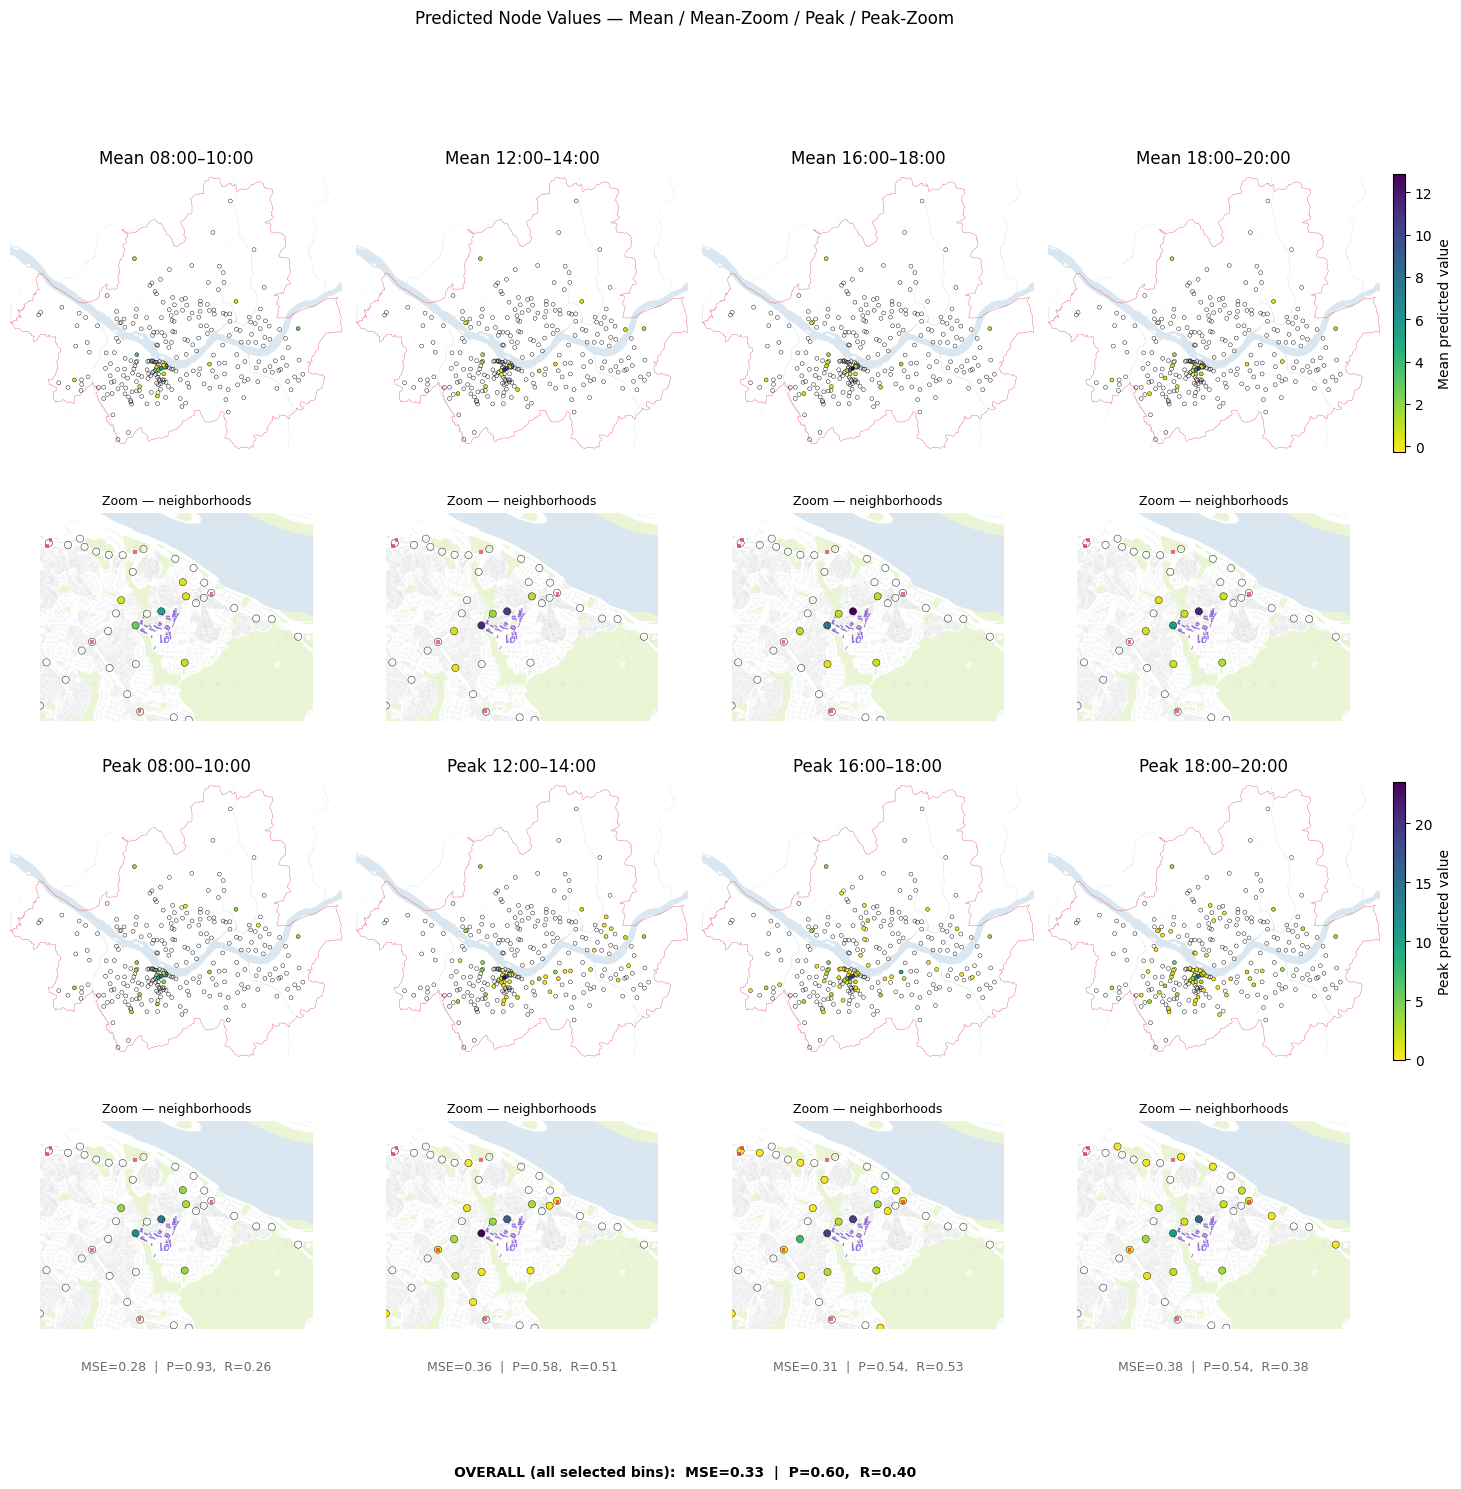

C:\Users\Michele\AppData\Local\Temp\ipykernel_20328\2232386207.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")
C:\Users\M

          node_x         node_y
0  201901.093053  460064.852487
1  195828.097002  444755.102147
2  196137.559766  444924.973015
3  195965.385663  444895.599804
4  195498.755705  444686.607997
Interval 08-10: selected bins = 8
Interval 12-14: selected bins = 8
Interval 16-18: selected bins = 8
Interval 18-20: selected bins = 8
    metrics: {'mse': 0.29302847385406494, 'precision': 1.0, 'recall': 0.2606060606060606, 'f1': 0.41346153846153844}
    metrics: {'mse': 0.5172049403190613, 'precision': 0.5858585858585859, 'recall': 0.48333333333333334, 'f1': 0.5296803652968036}
    metrics: {'mse': 0.37822258472442627, 'precision': 0.5471698113207547, 'recall': 0.5178571428571429, 'f1': 0.5321100917431193}
    metrics: {'mse': 0.40302902460098267, 'precision': 0.5377358490566038, 'recall': 0.36538461538461536, 'f1': 0.4351145038167939}
Overall scenario metrics: {'mse': 0.3978712260723114, 'precision': 0.6101694915254238, 'recall': 0.39059674502712477, 'f1': 0.4762954796030871}
Saved → D:/Deskto

C:\Users\Michele\AppData\Local\Temp\ipykernel_20328\859103428.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.98, 0.965])


Saved figure → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_hot_mean_ge_23C_baseline_grid_subset.png


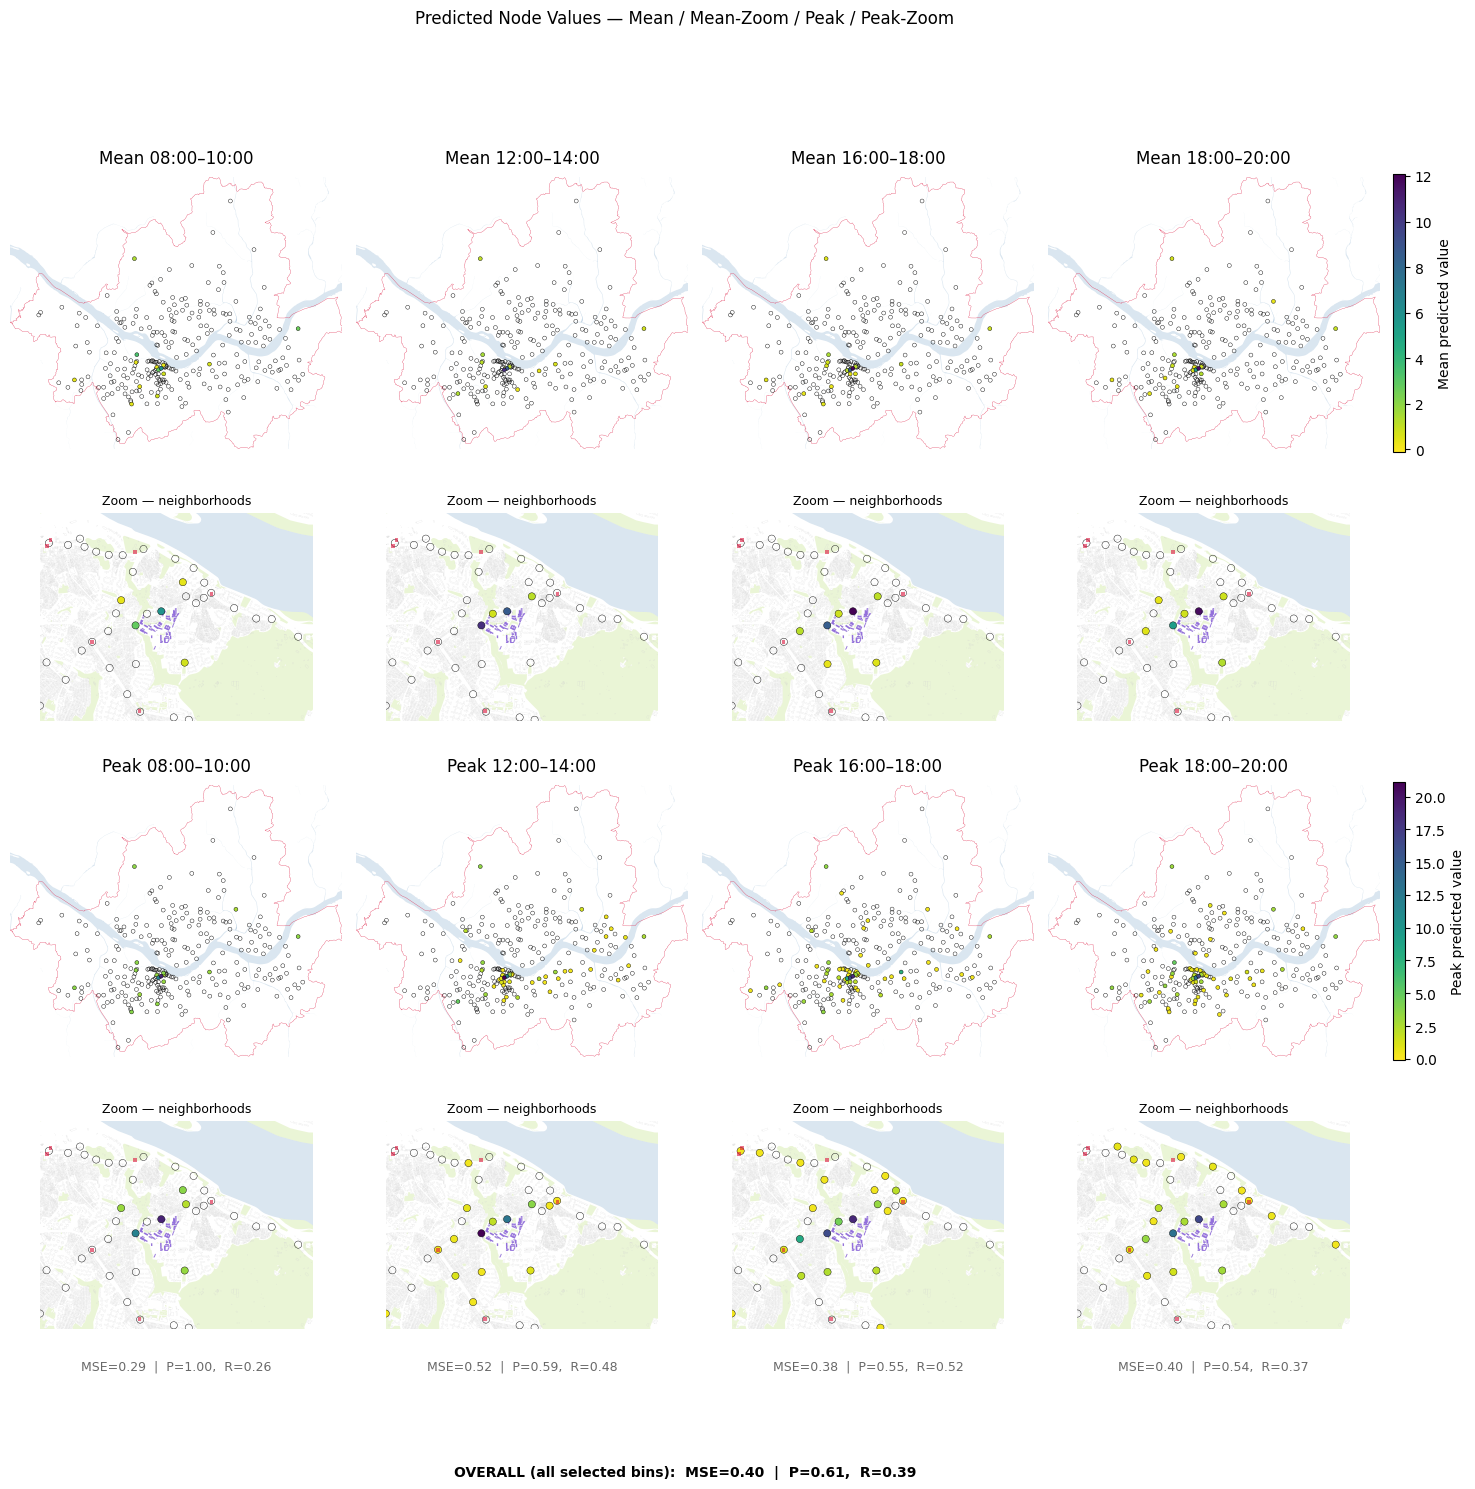

In [173]:
hot_csv = os.path.join(SCENARIO_DIR, "hot_temp_mean_ge_23.0C.csv")
hot_dates = load_scenario_dates(hot_csv)

generate_interval_maps(
    day_selector=hot_dates, 
    weekdays_only=True,
    zero_cutoff=0.3,
    cmap="viridis_r",
    save_prefix="interval_maps_hot_23C_climate",
    ckpt_path=CLIMATE,
    art_path=ART_CLIMATE
)
    
generate_interval_maps(
    day_selector=hot_dates, 
    weekdays_only=True,
    zero_cutoff=0.3,
    cmap="viridis_r",
    save_prefix="interval_maps_hot_mean_ge_23C_baseline",
    ckpt_path=BASELINE,
    art_path=ART_BASELINE
)

C:\Users\Michele\AppData\Local\Temp\ipykernel_20328\2232386207.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")
C:\Users\M

          node_x         node_y
0  201901.093053  460064.852487
1  195828.097002  444755.102147
2  196137.559766  444924.973015
3  195965.385663  444895.599804
4  195498.755705  444686.607997
Interval 08-10: selected bins = 9
Interval 12-14: selected bins = 9
Interval 16-18: selected bins = 9
Interval 18-20: selected bins = 9
    metrics: {'mse': 0.17955535650253296, 'precision': 0.9264705882352942, 'recall': 0.35795454545454547, 'f1': 0.5163934426229508}
    metrics: {'mse': 0.30511656403541565, 'precision': 0.4206896551724138, 'recall': 0.45864661654135336, 'f1': 0.43884892086330934}
    metrics: {'mse': 0.26587429642677307, 'precision': 0.5036496350364964, 'recall': 0.40828402366863903, 'f1': 0.45098039215686275}
    metrics: {'mse': 0.41482749581336975, 'precision': 0.4161073825503356, 'recall': 0.3974358974358974, 'f1': 0.4065573770491803}
Overall scenario metrics: {'mse': 0.29134345054626465, 'precision': 0.5110220440881763, 'recall': 0.4022082018927445, 'f1': 0.4501323918799647}

C:\Users\Michele\AppData\Local\Temp\ipykernel_20328\859103428.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.98, 0.965])


Saved figure → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_climate_grid_subset.png


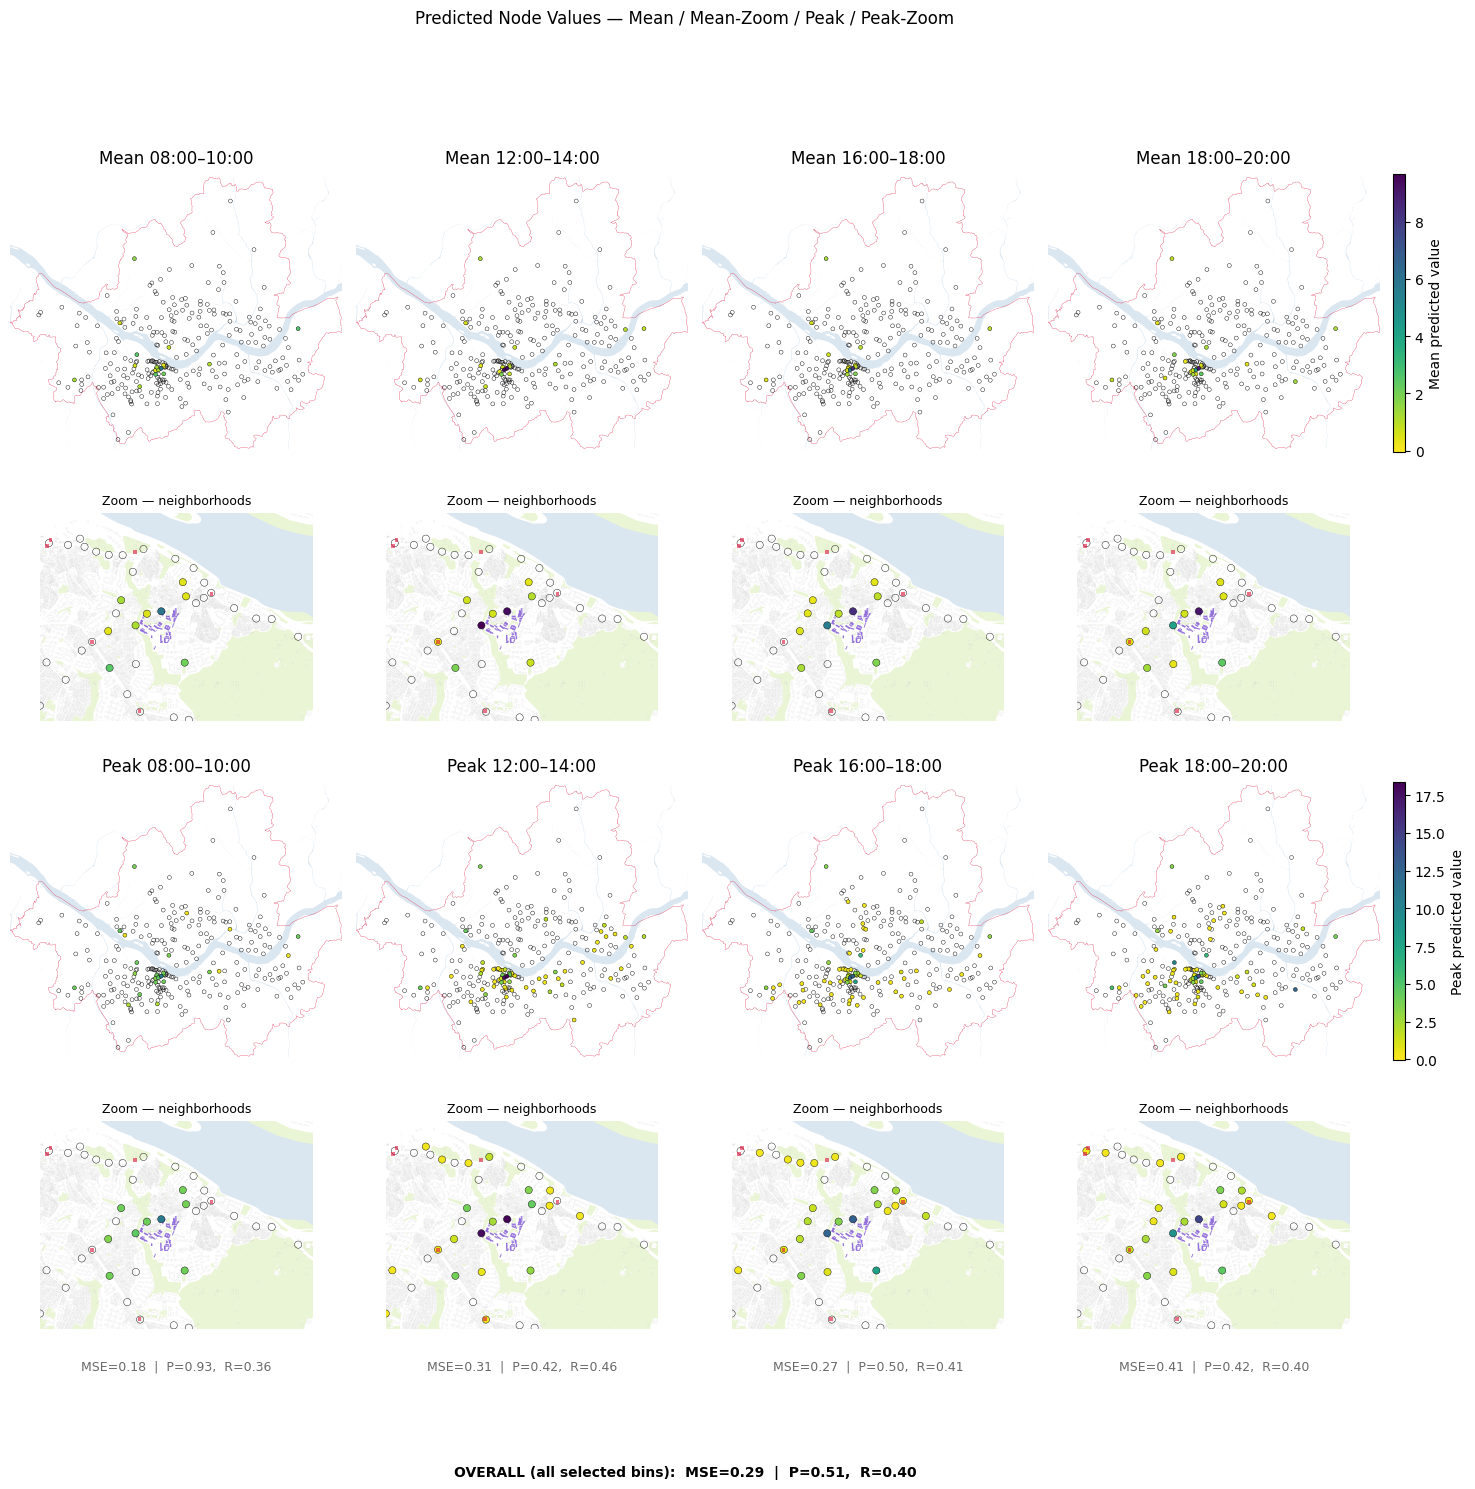

C:\Users\Michele\AppData\Local\Temp\ipykernel_20328\2232386207.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")
C:\Users\M

          node_x         node_y
0  201901.093053  460064.852487
1  195828.097002  444755.102147
2  196137.559766  444924.973015
3  195965.385663  444895.599804
4  195498.755705  444686.607997
Interval 08-10: selected bins = 9
Interval 12-14: selected bins = 9
Interval 16-18: selected bins = 9
Interval 18-20: selected bins = 9
    metrics: {'mse': 0.21079455316066742, 'precision': 1.0, 'recall': 0.3522727272727273, 'f1': 0.5210084033613446}
    metrics: {'mse': 0.32459327578544617, 'precision': 0.42857142857142855, 'recall': 0.45112781954887216, 'f1': 0.43956043956043955}
    metrics: {'mse': 0.3172873556613922, 'precision': 0.5149253731343284, 'recall': 0.40828402366863903, 'f1': 0.45544554455445546}
    metrics: {'mse': 0.41108912229537964, 'precision': 0.4178082191780822, 'recall': 0.391025641025641, 'f1': 0.40397350993377484}
Overall scenario metrics: {'mse': 0.31594109535217285, 'precision': 0.5228215767634855, 'recall': 0.39747634069400634, 'f1': 0.45161290322580644}
Saved → D:/De

C:\Users\Michele\AppData\Local\Temp\ipykernel_20328\859103428.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.98, 0.965])


Saved figure → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_cold_10C_baseline_grid_subset.png


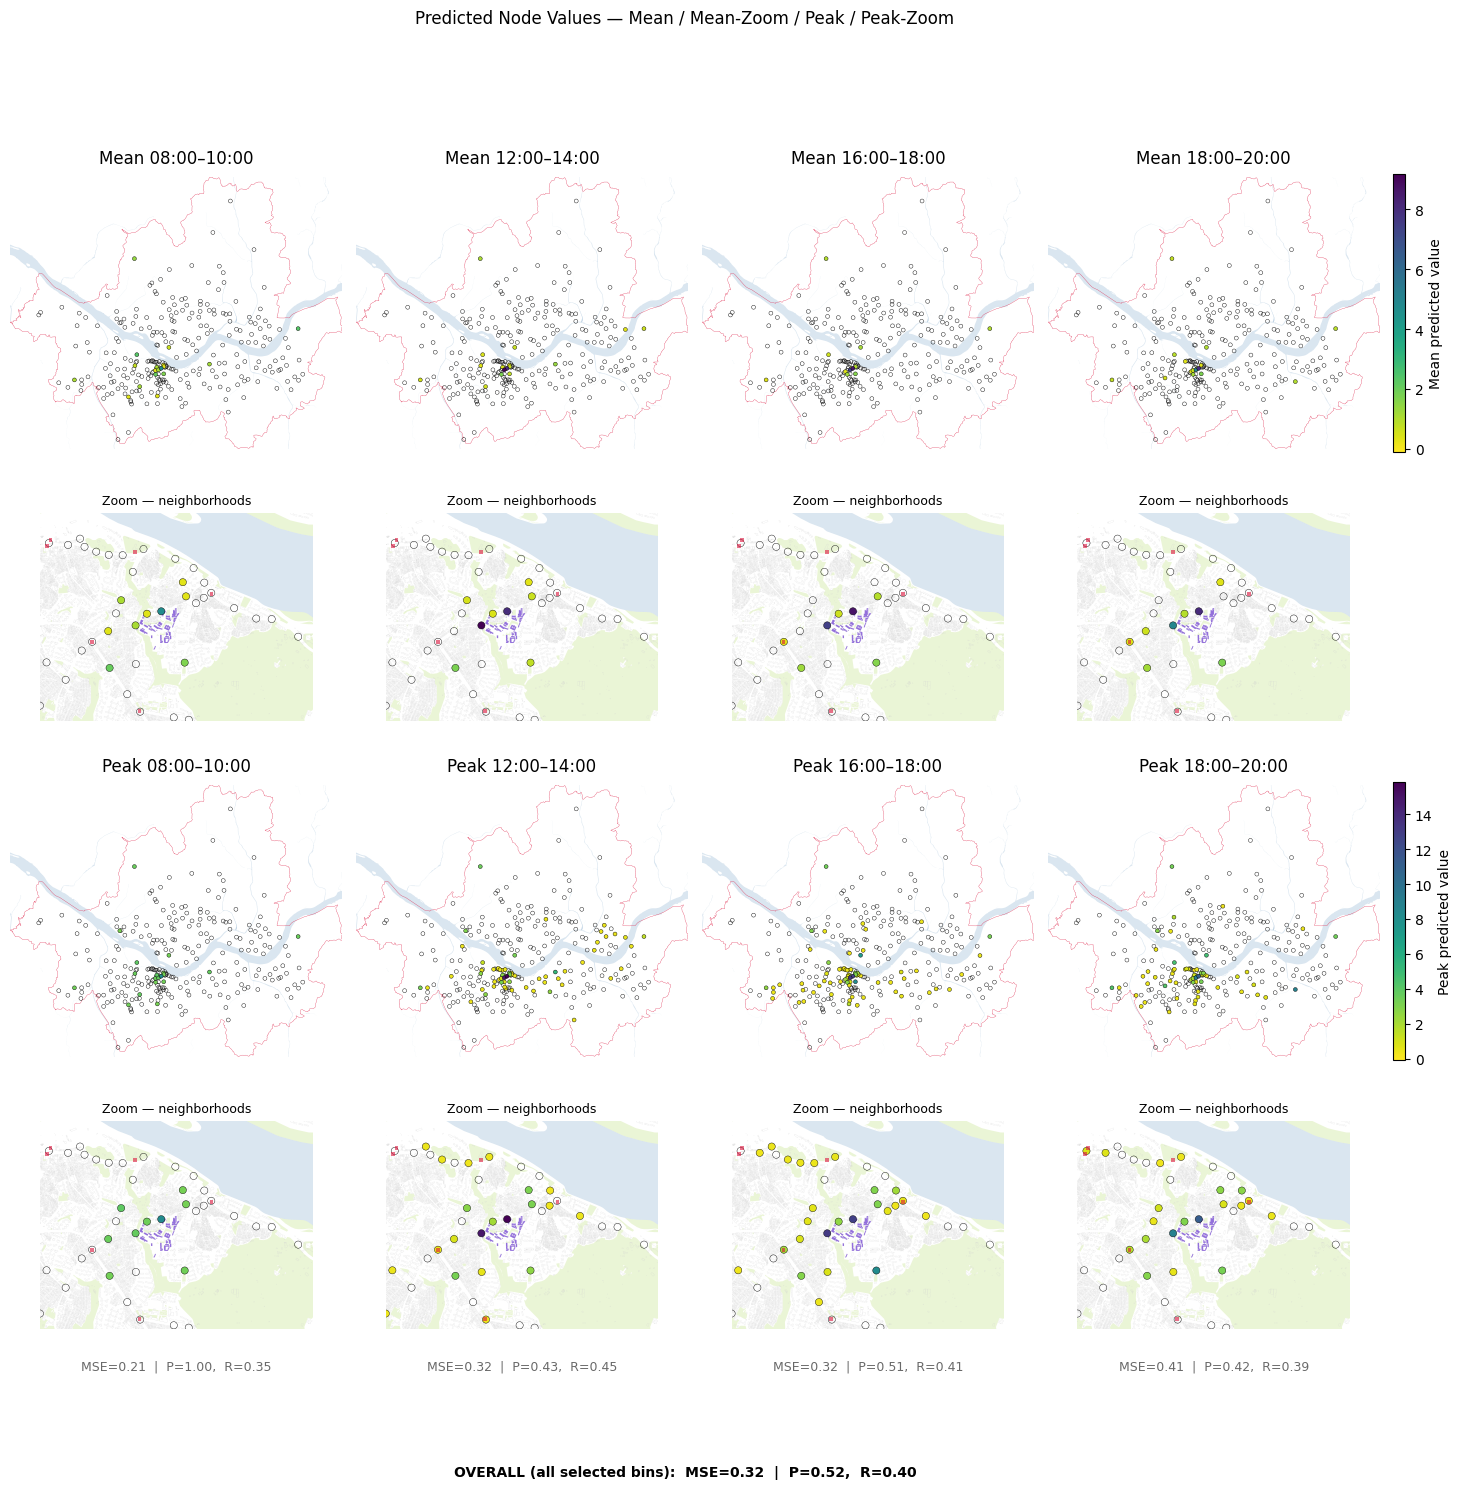

In [174]:
cold_csv = os.path.join(SCENARIO_DIR, "cold_temp_mean_le_10.0C.csv")
cold_dates = load_scenario_dates(cold_csv)

generate_interval_maps(
    day_selector=cold_dates, 
    weekdays_only=True,
    zero_cutoff=0.3,
    cmap="viridis_r",
    save_prefix="interval_maps_cold_10C_climate",
    ckpt_path=CLIMATE,
    art_path=ART_CLIMATE
)

generate_interval_maps(
    day_selector=cold_dates, 
    weekdays_only=True,
    zero_cutoff=0.3,
    cmap="viridis_r",
    save_prefix="interval_maps_cold_10C_baseline",
    ckpt_path=BASELINE,
    art_path=ART_BASELINE
)

C:\Users\Michele\AppData\Local\Temp\ipykernel_20328\2232386207.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")
C:\Users\M

          node_x         node_y
0  201901.093053  460064.852487
1  195828.097002  444755.102147
2  196137.559766  444924.973015
3  195965.385663  444895.599804
4  195498.755705  444686.607997
Interval 08-10: selected bins = 9
Interval 12-14: selected bins = 9
Interval 16-18: selected bins = 9
Interval 18-20: selected bins = 9
    metrics: {'mse': 0.26985394954681396, 'precision': 0.921875, 'recall': 0.31891891891891894, 'f1': 0.4738955823293173}
    metrics: {'mse': 0.4445914924144745, 'precision': 0.5271317829457365, 'recall': 0.4146341463414634, 'f1': 0.4641638225255973}
    metrics: {'mse': 0.303335964679718, 'precision': 0.5873015873015873, 'recall': 0.3978494623655914, 'f1': 0.47435897435897434}
    metrics: {'mse': 0.47136273980140686, 'precision': 0.4327485380116959, 'recall': 0.39572192513368987, 'f1': 0.4134078212290503}
Overall scenario metrics: {'mse': 0.37228602170944214, 'precision': 0.5612244897959183, 'recall': 0.3808864265927978, 'f1': 0.4537953795379538}
Saved → D:/Des

C:\Users\Michele\AppData\Local\Temp\ipykernel_20328\859103428.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.98, 0.965])


Saved figure → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_humidity_70C_climate_grid_subset.png


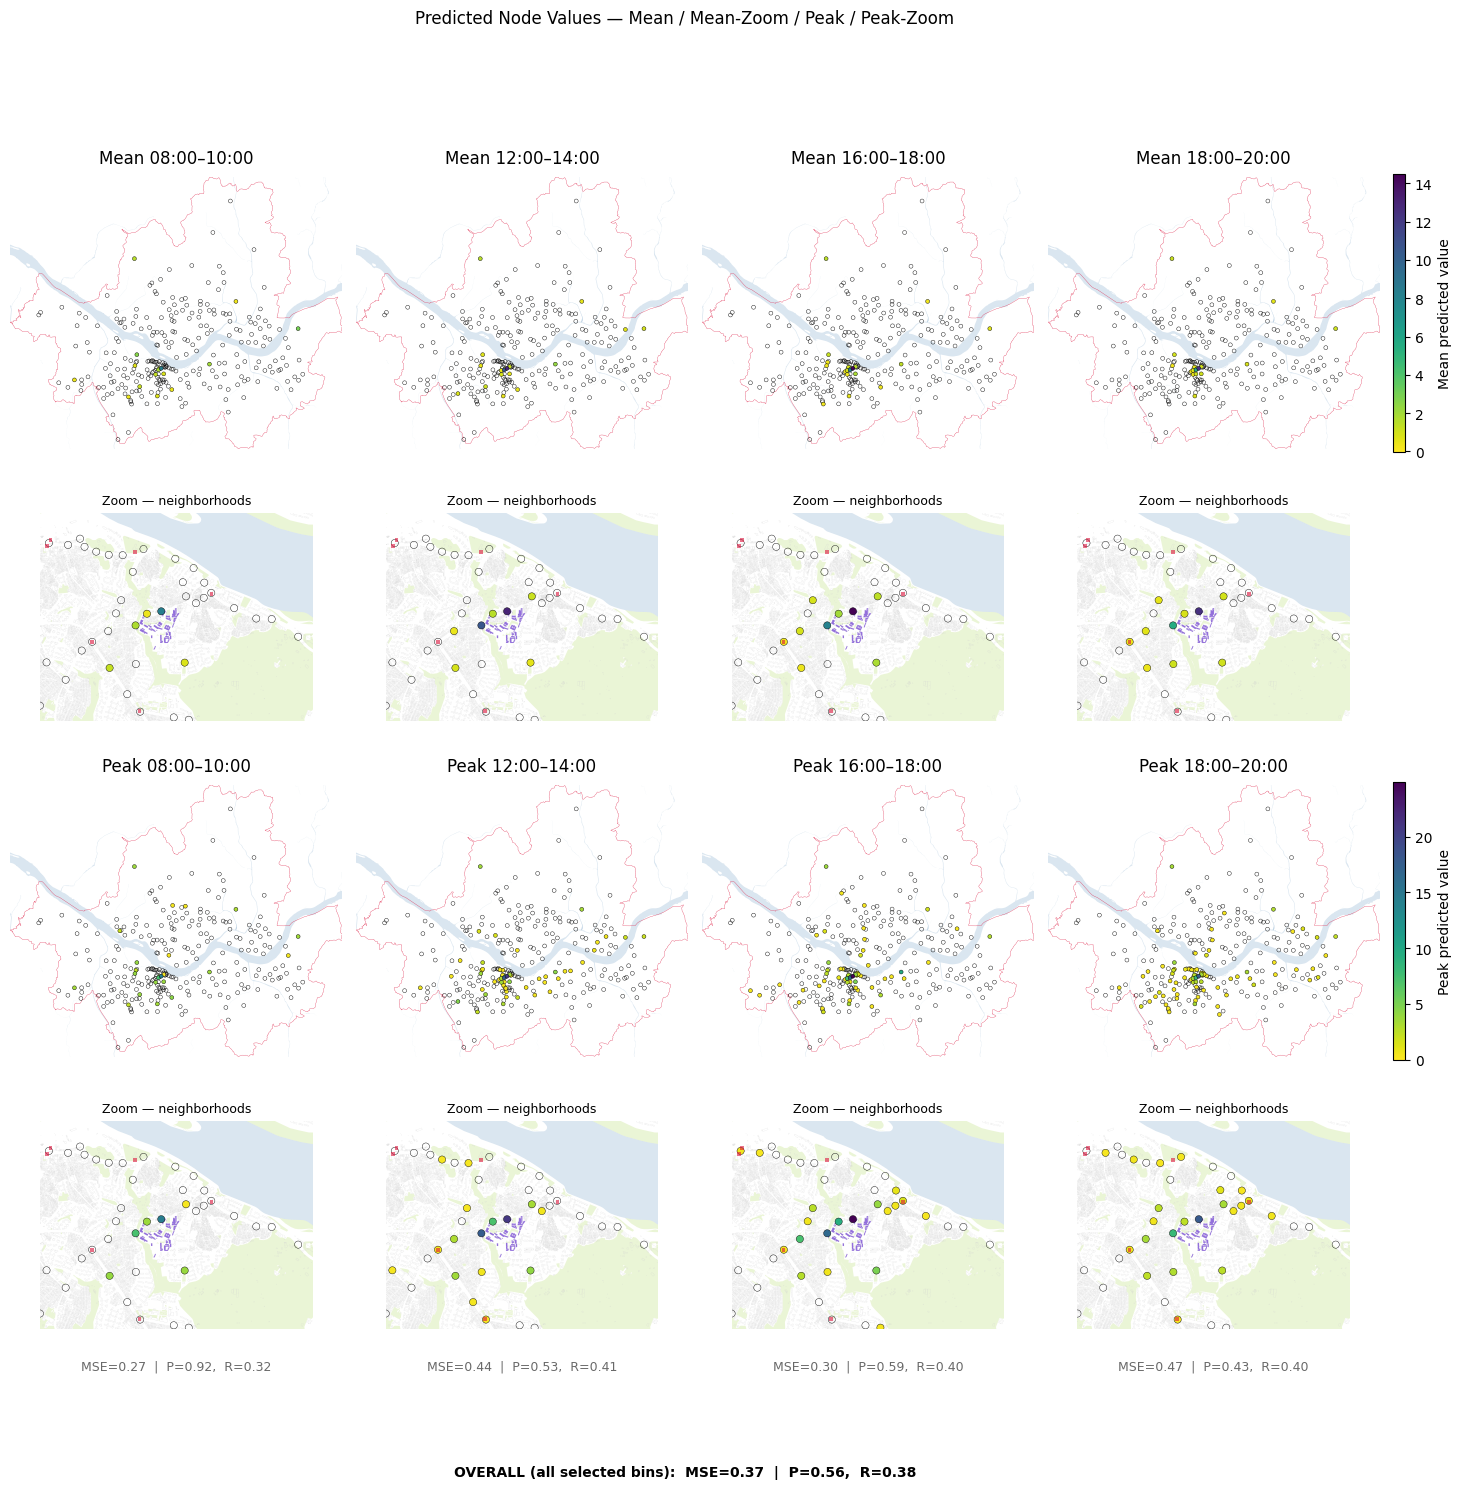

C:\Users\Michele\AppData\Local\Temp\ipykernel_20328\2232386207.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")
C:\Users\M

          node_x         node_y
0  201901.093053  460064.852487
1  195828.097002  444755.102147
2  196137.559766  444924.973015
3  195965.385663  444895.599804
4  195498.755705  444686.607997
Interval 08-10: selected bins = 9
Interval 12-14: selected bins = 9
Interval 16-18: selected bins = 9
Interval 18-20: selected bins = 9
    metrics: {'mse': 0.29880914092063904, 'precision': 1.0, 'recall': 0.3081081081081081, 'f1': 0.47107438016528924}
    metrics: {'mse': 0.5213521718978882, 'precision': 0.5234375, 'recall': 0.40853658536585363, 'f1': 0.4589041095890411}
    metrics: {'mse': 0.3536107540130615, 'precision': 0.6016260162601627, 'recall': 0.3978494623655914, 'f1': 0.47896440129449835}
    metrics: {'mse': 0.5080701112747192, 'precision': 0.4157303370786517, 'recall': 0.39572192513368987, 'f1': 0.4054794520547945}
Overall scenario metrics: {'mse': 0.4204604923725128, 'precision': 0.5596707818930041, 'recall': 0.3767313019390582, 'f1': 0.4503311258278146}
Saved → D:/Desktop/MSc Thesi

C:\Users\Michele\AppData\Local\Temp\ipykernel_20328\859103428.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.98, 0.965])


Saved figure → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_humidity_70C_baseline_grid_subset.png


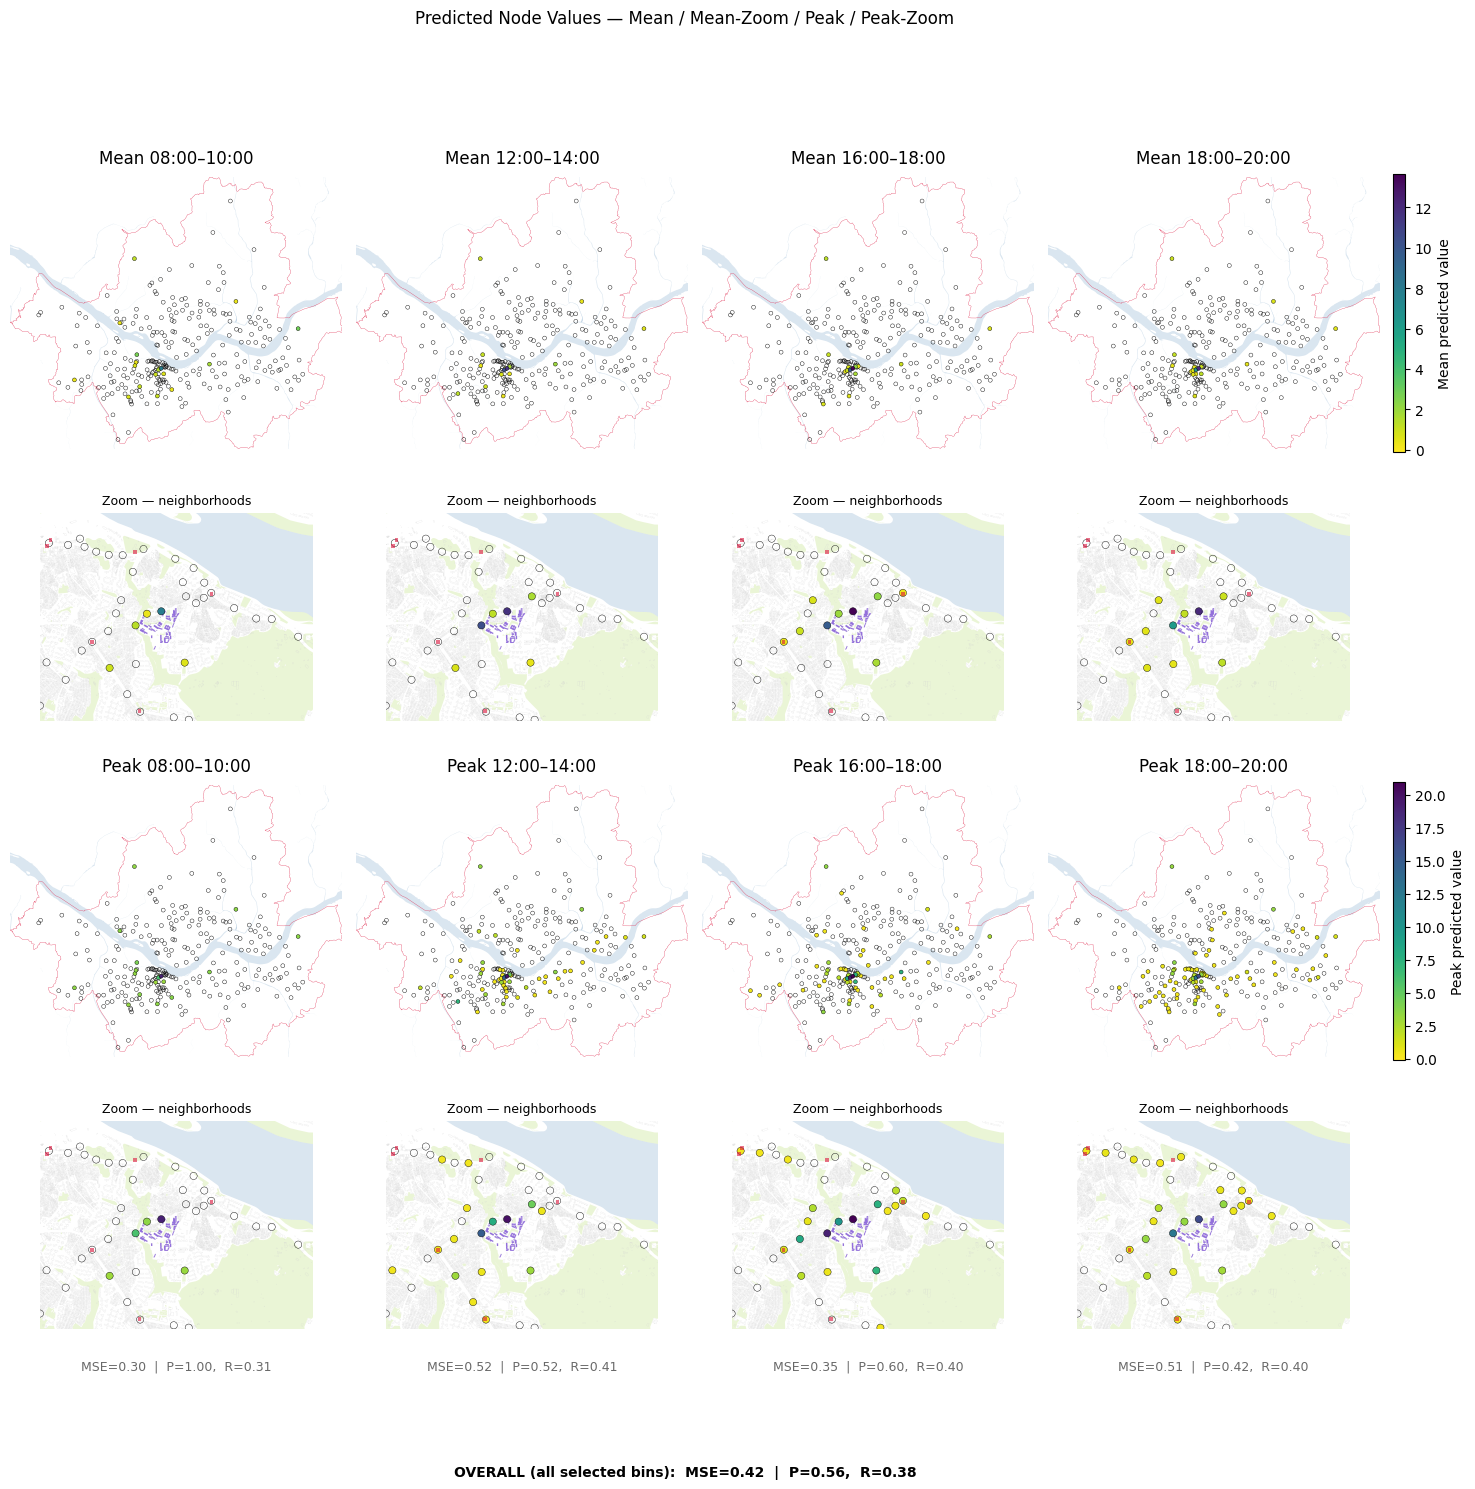

In [175]:
humid_csv = os.path.join(SCENARIO_DIR, "humidity_mean_ge_70.0C.csv")
humid_dates = load_scenario_dates(humid_csv)

generate_interval_maps(
    day_selector=humid_dates, 
    weekdays_only=True,
    zero_cutoff=0.3,
    cmap="viridis_r",
    save_prefix="interval_maps_humidity_70C_climate",
    ckpt_path=CLIMATE,
    art_path=ART_CLIMATE
)

generate_interval_maps(
    day_selector=humid_dates, 
    weekdays_only=True,
    zero_cutoff=0.3,
    cmap="viridis_r",
    save_prefix="interval_maps_humidity_70C_baseline",
    ckpt_path=BASELINE,
    art_path=ART_BASELINE
)

C:\Users\Michele\AppData\Local\Temp\ipykernel_20328\2232386207.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")
C:\Users\M

          node_x         node_y
0  201901.093053  460064.852487
1  195828.097002  444755.102147
2  196137.559766  444924.973015
3  195965.385663  444895.599804
4  195498.755705  444686.607997
Interval 08-10: selected bins = 32
Interval 12-14: selected bins = 32
Interval 16-18: selected bins = 32
Interval 18-20: selected bins = 32
    metrics: {'mse': 0.2257513552904129, 'precision': 1.0, 'recall': 0.3259493670886076, 'f1': 0.4916467780429594}
    metrics: {'mse': 0.38541609048843384, 'precision': 0.6655737704918033, 'recall': 0.41855670103092785, 'f1': 0.5139240506329114}
    metrics: {'mse': 0.28134045004844666, 'precision': 0.7465277777777778, 'recall': 0.37521815008726006, 'f1': 0.4994192799070848}
    metrics: {'mse': 0.3689837157726288, 'precision': 0.6447368421052632, 'recall': 0.31766612641815234, 'f1': 0.4256243213897937}
Overall scenario metrics: {'mse': 0.3160786032676697, 'precision': 0.743427017225748, 'recall': 0.3554399653229302, 'f1': 0.4809384164222874}
Saved → D:/Deskt

C:\Users\Michele\AppData\Local\Temp\ipykernel_20328\859103428.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.98, 0.965])


Saved figure → D:/Desktop/MSc Thesis/Results/interval_maps\interval_maps_full_grid_alldays.png


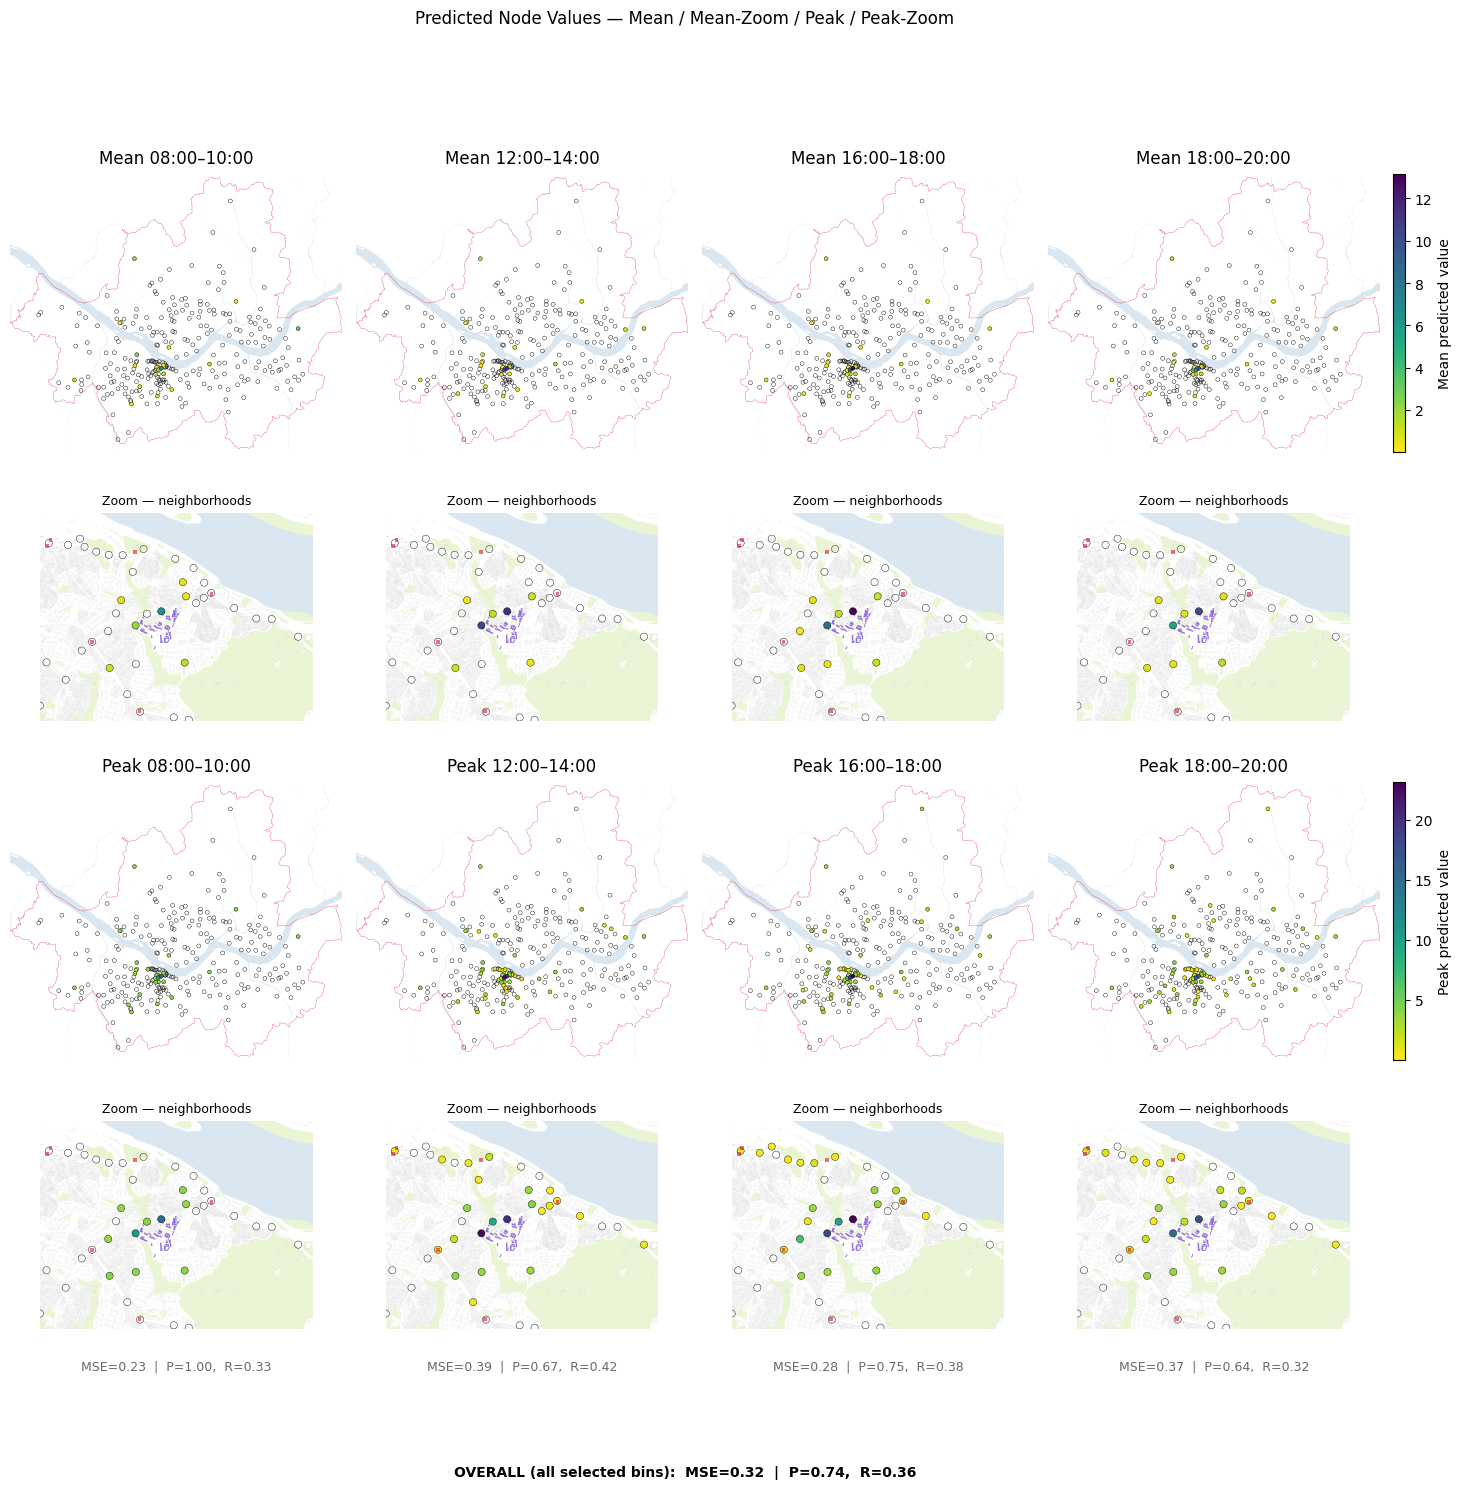

In [176]:
generate_interval_maps(day_selector=None, 
                       weekdays_only=True, 
                       zero_cutoff=0.3, 
                       cmap="viridis_r",
                       save_prefix="interval_maps_full",
                       ckpt_path=CLIMATE_URBAN,
                       art_path=ART_CLIMATE_URBAN)